# Perceptrón Multicapa

Como modelo simple para ir aprendiendo el uso de PyTorch vamos a crear un perceptrón multicapa y entrenarlo con los datos en bruto.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%reload_ext autoreload

import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import repackage
repackage.up()

from modelo_perceptron import *
from modelo_lstm import *
from fluxdataset import *
from utils import *

In [2]:
PATH = "../datos/"
TRAIN_FILE = "exoTrain.csv"
TEST_FILE = "exoTest.csv"

In [3]:
#leemos los datos de ambos datasets
df_train_raw = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test_raw = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
train_x, train_y = generate_x_y_df(df_train_raw)
train_y = train_y.add(-1) #pasamos de 1-2 a 0-1

In [4]:
train_x.shape, train_y.shape

((5087, 3197), (5087,))

In [5]:
#definicion del modelo
class Perceptron(torch.nn.Module):
    #definimos la estructura de la red
    #capa de entrada x con activacion relu
    #capa oculta con activacion relu
    #capa de salida con activacion softmax
    def __init__(self, n_features, n_hidden):
        super(Perceptron, self).__init__()
        self.fully_connected_1 = torch.nn.Linear(n_features, n_hidden)
        self.fully_connected_2 = torch.nn.Linear(n_hidden, n_hidden)
        self.fully_connected_3 = torch.nn.Linear(n_hidden, 2)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = 1)
        #self.softmax = torch.nn.Sigmoid()
        
    #definimos el flujo 
    def forward(self, x):
        x = self.relu(self.fully_connected_1(x))
        x = self.relu(self.fully_connected_2(x))
        x = self.softmax(self.fully_connected_3(x))
        #x = self.fully_connected_3(x)
        return x

In [6]:
learning_rate = 0.01
epochs = 50
train_x_tensor = torch.tensor(train_x.values).float()
train_y_tensor = torch.tensor(train_y.values)

In [7]:
#instanciamos nuestro modelo
modelo = Perceptron(n_features = train_x.shape[1], n_hidden = 300) 

In [8]:
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()

In [9]:
for epoch in range(epochs):
    #limpiamos los gradientes
    optimizer.zero_grad()
    #propagamos la entrada hacia delante
    predictions = modelo(train_x_tensor)
    #calculamos la perdida
    loss = loss_function(predictions.squeeze(), train_y_tensor)
    #ejecutamos back-propagation
    loss.backward()
    #actualizamos los pesos
    optimizer.step()
    #imprimimos
    if epoch % 10 == 0:
        print('Epoch: {} loss: {}'.format(epoch, loss.item()))
        
print('Epoch: {} loss: {}'.format(epochs, loss.item()))

Epoch: 0 loss: 0.4815114438533783
Epoch: 10 loss: 0.32762759923934937
Epoch: 20 loss: 0.32567983865737915
Epoch: 30 loss: 0.3246314525604248
Epoch: 40 loss: 0.32396364212036133
Epoch: 50 loss: 0.32353726029396057


In [10]:
predictions

tensor([[1.0000e+00, 4.4413e-39],
        [1.0000e+00, 2.0166e-11],
        [1.0000e+00, 0.0000e+00],
        ...,
        [1.0000e+00, 2.3097e-12],
        [9.9948e-01, 5.1692e-04],
        [1.0000e+00, 4.0380e-15]], grad_fn=<SoftmaxBackward>)

Como sospechabamos, sin hacer ningun tratamiento previo a los datos, el modelo solamente devuelve que no existe exoplaneta con certeza absoluta en practicamente todos los casos.

## Preparando los datos

- normalizar
- eliminar picos de luz

In [3]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_test = pd.read_csv(f'{PATH}{TEST_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_test['LABEL'] = df_test['LABEL'].add(-1)

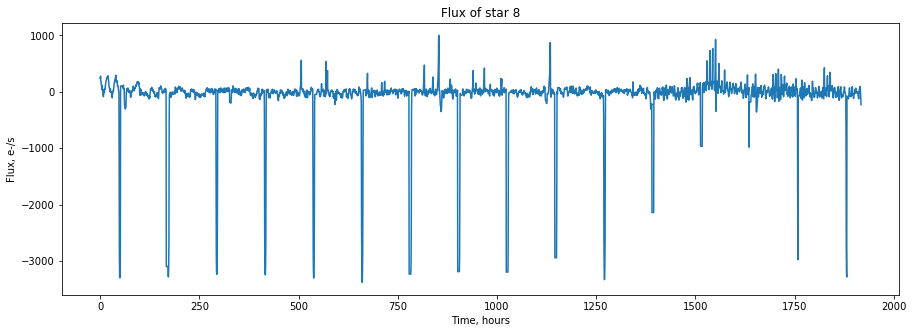

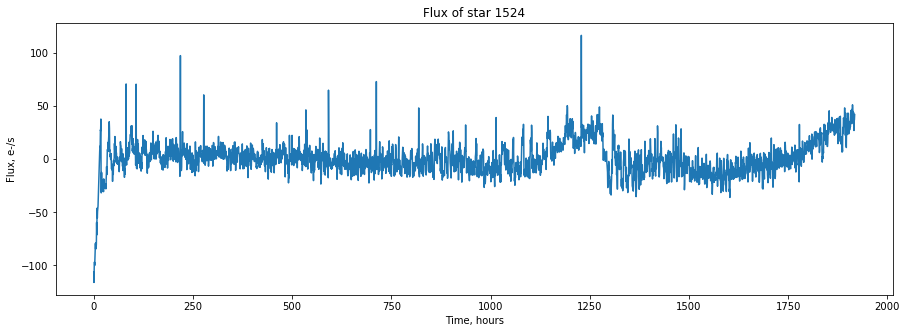

In [4]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [1523])

In [5]:
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:,1:] = df_train.iloc[:,1:].apply(z_score_normalizing, axis = 1)

Veamos como queda tras procesar el dataset

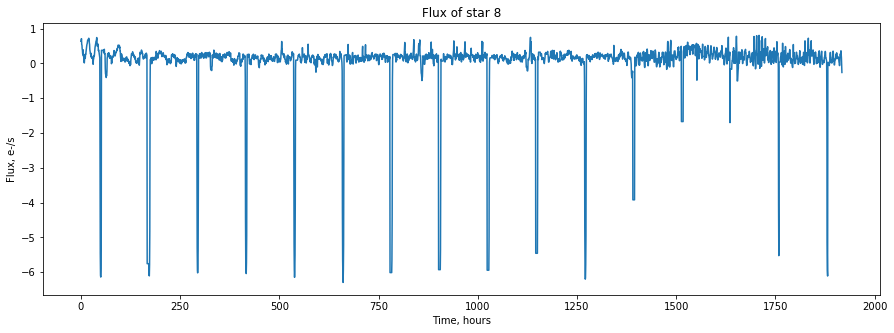

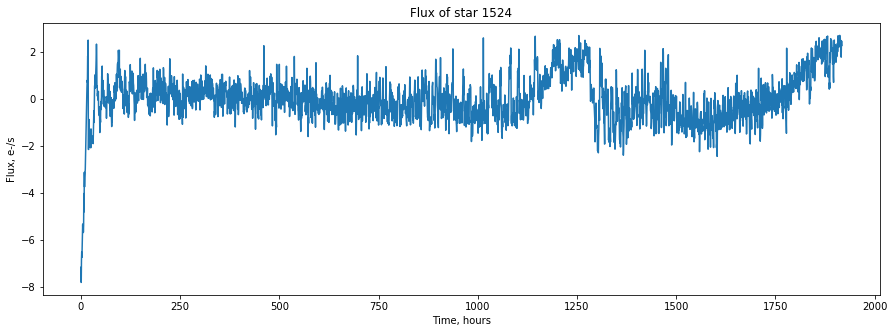

In [6]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [1523])

In [7]:
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

In [8]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[1], max(weights)/weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [13]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 0.1369473959385367 Validation loss 0.007528446149080992
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.03801965976904944 Validation loss 0.006633243057876825
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.03224771676027815 Validation loss 0.005773351527750492
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.027027997513408862 Validation loss 0.004391402006149292
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.022283967309803386 Validation loss 0.0038814132567495108
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.017812918753715674 Validation loss 0.003137786639854312
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.01416527902710738 Validation loss 

Score 0.4965585172176361 at epoch 68
Epoch: 68 Train loss 0.0001105943534820669 Validation loss 0.0005639620358124375
Score 0.4965585172176361 at epoch 69
Epoch: 69 Train loss 0.00010761072360125852 Validation loss 0.0005644484772346914
Score 0.4965585172176361 at epoch 70
Epoch: 70 Train loss 0.00010403760821283836 Validation loss 0.0005645314231514931
Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.00010094203296102038 Validation loss 0.0005650350940413773
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 9.814038017699937e-05 Validation loss 0.0005655577988363802
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 9.521430480672458e-05 Validation loss 0.0005658282898366451
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 9.26492255137025e-05 Validation loss 0.0005660898168571293
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 9.018036305892017e-05 Validation loss 0.0005664047785103321
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train l

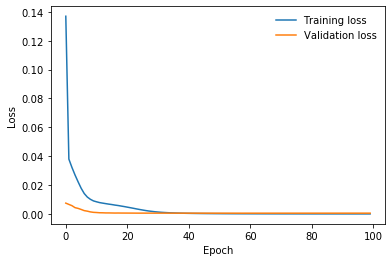

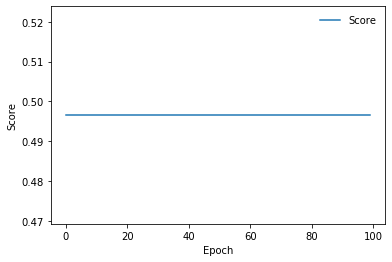

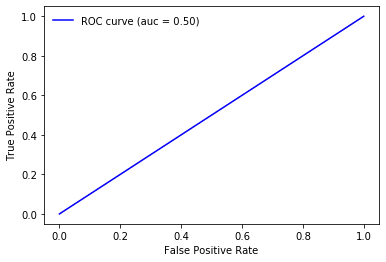

In [14]:
resultado.plot_graphics()

In [15]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[1], max(weights)/weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [16]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 0.18716327870069632 Validation loss 0.02573731355369091
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.11706829467867069 Validation loss 0.004310250747948885
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.05308731362074558 Validation loss 0.015739375725388527
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.11214694294740418 Validation loss 0.004173249006271362
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.28645931175445294 Validation loss 0.0044064936228096485
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.037216407687958204 Validation loss 0.008657285012304783
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.07152638067256516 Validation loss 0.

Score 0.4965585172176361 at epoch 70
Epoch: 70 Train loss 0.020090540796884448 Validation loss 0.06401747465133667
Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.020103865949761955 Validation loss 0.0641813799738884
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 0.020084202655703196 Validation loss 0.06423849612474442
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.020090907153099115 Validation loss 0.06428500264883041
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.020059575847091487 Validation loss 0.06433708965778351
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.020108904636462723 Validation loss 0.0646028146147728
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.020104175293474878 Validation loss 0.06500641256570816
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.020094289943685697 Validation loss 0.06530465930700302
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.020099531842683985 Val

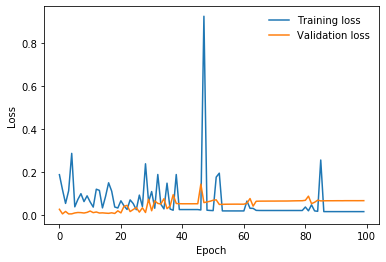

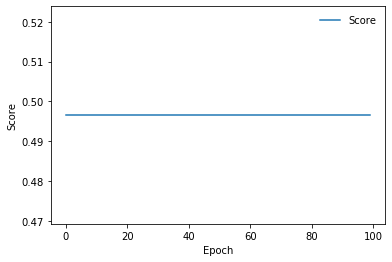

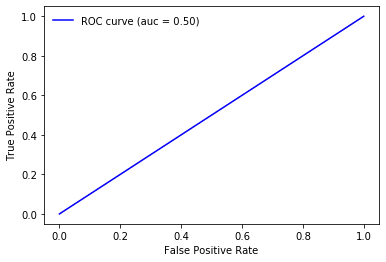

In [17]:
resultado.plot_graphics()

In [19]:
modelo = Perceptron(output = 1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [20]:
resultado = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 22.268746338385622 Validation loss 1.3244900703430176
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 2.588646560460695 Validation loss 1.325885534286499
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 4.443900197305023 Validation loss 12.26632022857666
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.9401298192048249 Validation loss 1.3423877954483032
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 1.3829692125173987 Validation loss 1.3362833261489868
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 3.0175665445570865 Validation loss 1.3362154960632324
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 1.3801332858915119 Validation loss 1.3333789110183716
Score 0

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3800453363091705 Validation loss 1.3297368288040161
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.379381861631056 Validation loss 1.329773187637329
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3788851304780647 Validation loss 1.3297557830810547
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3808129161669522 Validation loss 1.329788088798523
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3796037578758502 Validation loss 1.3298012018203735
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.3803255586278527 Validation loss 1.329824686050415
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3799164328293954 Validation loss 1.3298498392105103
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3791409074674368 Validation loss 1.3298763036727905
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.3795112989019118 Validation loss 1.3298779726028

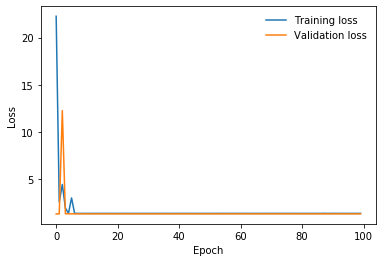

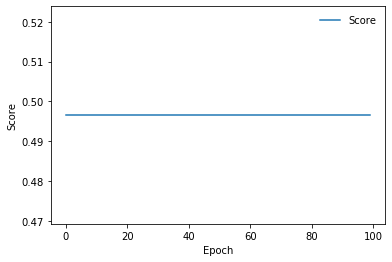

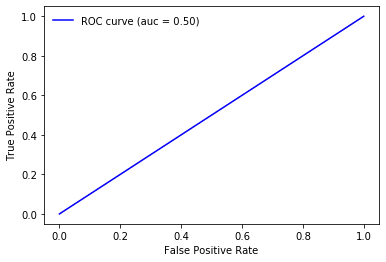

In [21]:
resultado.plot_graphics()

## Reduciendo el dataset

In [9]:
# Creamos un mini dataset balanceado, con todos los casos positivos que tenemos
# y un numero igual de casos negativos
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)

df_train_little = df_train[df_train.LABEL.eq(1)]
df_train_little = df_train_little.append(df_train[df_train.LABEL.eq(0)].sample(n = len(df_train_little)))

df_train_little.iloc[:, 1:] = reduce_upper_outliers(df_train_little.iloc[:, 1:], 0.01)
df_train_little.iloc[:,1:] = df_train_little.iloc[:,1:].apply(z_score_normalizing, axis = 1)

validation_proportion = 0.2
df_train_little, df_validation_little = split_train_df(df_train_little, validation_proportion)

In [10]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_mini"
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [12]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, 
                        df_train_little, df_validation_little, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	2		5
Positivos	0		7

Acierto: 0.6428571939468384 Sensibilidad: 1.0 Especificidad: 0.2857142984867096 Score: 0.4132653474807739
New model saved
Score 0.4132653474807739 at epoch 0
Epoch: 0 Train loss 0.7162607262531916 Validation loss 0.701729953289032
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	4		3
Positivos	1		6

Acierto: 0.7142857313156128 Sensibilidad: 0.8571428656578064 Especificidad: 0.5714285969734192 Score: 0.5102040767669678
New model saved
Score 0.5102040767669678 at epoch 1
Epoch: 1 Train loss 0.4890909125407537 Validation loss 0.9960818886756897
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	6		1
Positivos	1		6

Acierto: 0.8571429252624512 Sensibilidad: 0.8571428656578064 Especificidad: 0.8571428656578064 Score: 0.7346939444541931
New model saved
Score 0.7346939444541931 at epoch 2
Epoch: 2 Train loss 0.214739364385

Score 0.3265306353569031 at epoch 66
Epoch: 66 Train loss 1.1920928955078126e-08 Validation loss 2.60784649848938
Score 0.3265306353569031 at epoch 67
Epoch: 67 Train loss 1.1920928955078126e-08 Validation loss 2.616018772125244
Score 0.3265306353569031 at epoch 68
Epoch: 68 Train loss 1.1920928955078126e-08 Validation loss 2.6219189167022705
Score 0.3265306353569031 at epoch 69
Epoch: 69 Train loss 1.5894571940104166e-08 Validation loss 2.6168875694274902
Score 0.3265306353569031 at epoch 70
Epoch: 70 Train loss 1.1920928955078126e-08 Validation loss 2.622772455215454
Score 0.3265306353569031 at epoch 71
Epoch: 71 Train loss 1.1920928955078126e-08 Validation loss 2.6292779445648193
Score 0.3265306353569031 at epoch 72
Epoch: 72 Train loss 1.1920928955078126e-08 Validation loss 2.634572744369507
Score 0.3265306353569031 at epoch 73
Epoch: 73 Train loss 1.1920928955078126e-08 Validation loss 2.6395137310028076
Score 0.3265306353569031 at epoch 74
Epoch: 74 Train loss 1.1920928955078126e

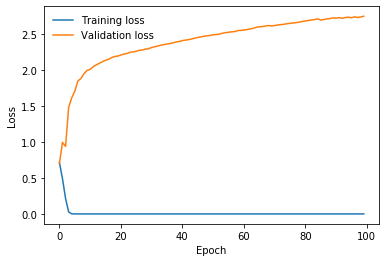

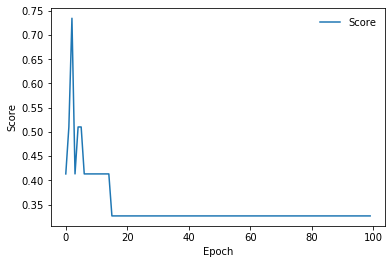

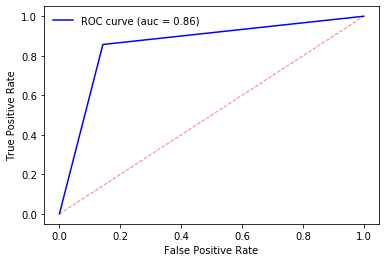

In [13]:
resultado.plot_graphics()

## Suavizando la señal

Probamos a suavizar la señal reduciéndola con un suavizado gaussiano

In [14]:
epochs = 100
learning_rate = 0.001
alpha = 0.5
beta = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

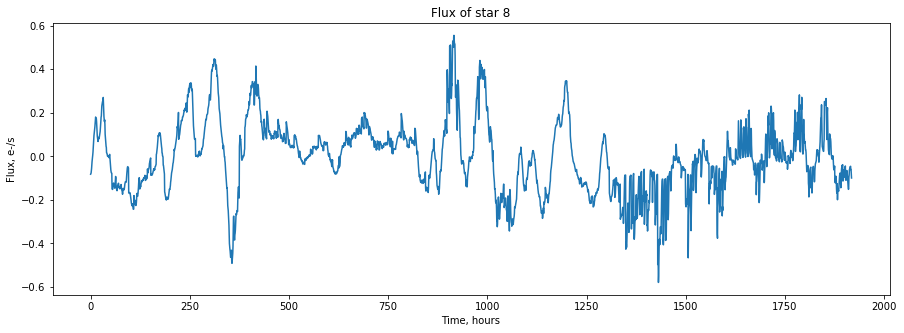

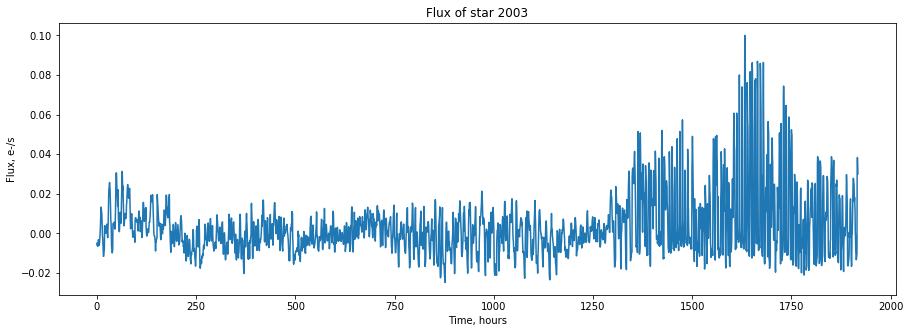

In [16]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [2002])

In [17]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_diferencia"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[1], max(weights)/weights[0]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [19]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 0.046419952191865524 Validation loss 0.01596849225461483
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.04523799946939143 Validation loss 0.01421370543539524
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.044418488966495015 Validation loss 0.012868225574493408
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.043849115933901076 Validation loss 0.011863338761031628
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.043433050148080944 Validation loss 0.011043161153793335
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.04312090071201947 Validation loss 0.010418819263577461
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.042880988765435855 Validation loss 

Score 0.4965585172176361 at epoch 70
Epoch: 70 Train loss 0.027621008019929276 Validation loss 0.003913525491952896
Score 0.4965585172176361 at epoch 71
Epoch: 71 Train loss 0.02692163189853497 Validation loss 0.003970208577811718
Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 0.02617425253659458 Validation loss 0.0038316049613058567
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 0.025415865415100707 Validation loss 0.003951081074774265
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 0.02460235039861152 Validation loss 0.0039191702380776405
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 0.02373349184339938 Validation loss 0.00401638587936759
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 0.022824776231386606 Validation loss 0.0042567807249724865
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 0.02188368272650413 Validation loss 0.004407323431223631
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 0.020932139019915

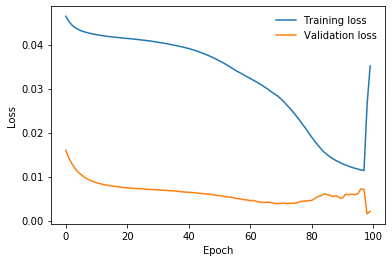

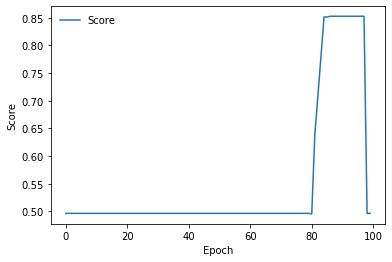

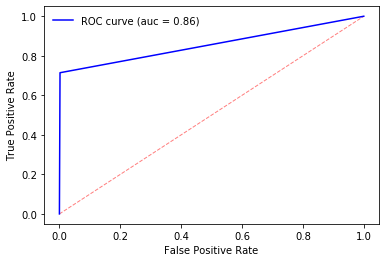

In [20]:
resultado.plot_graphics()

SGD, solo filtro

In [21]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)

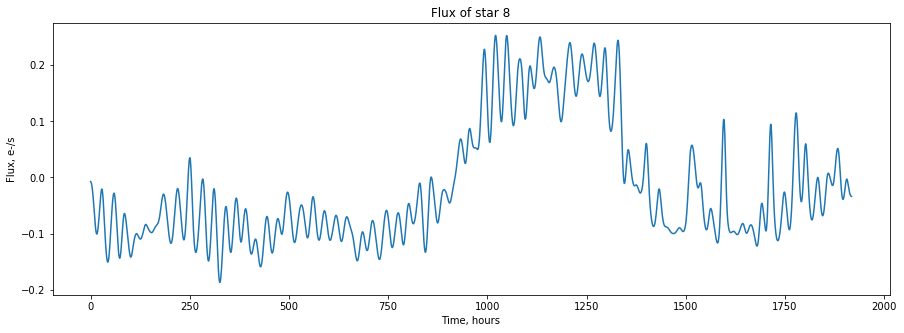

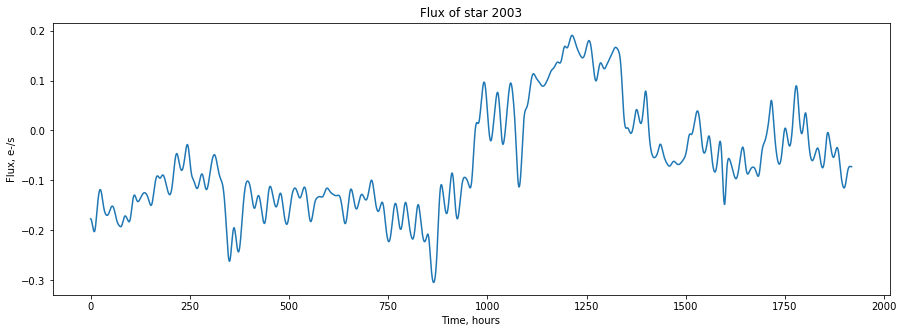

In [22]:
show_flux_plot(df_train.drop('LABEL', axis = 1), [7])
show_flux_plot(df_train.drop('LABEL', axis = 1), [2002])

In [23]:
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_sgd_cross_solo_filtro"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.SGD(modelo.parameters(), lr = learning_rate)

In [24]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 0.18673607721668498 Validation loss 1.4748378992080688
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.03687296645940082 Validation loss 1.1957499980926514
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.03075466352247196 Validation loss 1.0448744297027588
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.028199086464593685 Validation loss 0.9691715240478516
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.026259520671877288 Validation loss 0.8936371207237244
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.02458611753121641 Validation loss 0.853570282459259
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.023357593368839573 Validation loss 0.81225544214

Score 0.8554572463035583 at epoch 64
Epoch: 64 Train loss 0.0006132124680327824 Validation loss 0.1583826094865799
Score 0.9276584386825562 at epoch 65
Epoch: 65 Train loss 0.000726413697516889 Validation loss 0.1071687787771225
Score 0.9276584386825562 at epoch 66
Epoch: 66 Train loss 0.0006557361939029553 Validation loss 0.08449782431125641
Score 1.0 at epoch 67
Epoch: 67 Train loss 0.0006193929500603266 Validation loss 0.057552918791770935
Score 1.0 at epoch 68
Epoch: 68 Train loss 0.0006118856862425365 Validation loss 0.05245497077703476
Score 1.0 at epoch 69
Epoch: 69 Train loss 0.0005772580683267966 Validation loss 0.048820771276950836
Score 1.0 at epoch 70
Epoch: 70 Train loss 0.0005740132978579593 Validation loss 0.05176541581749916
Score 0.9276584386825562 at epoch 71
Epoch: 71 Train loss 0.0005844613952154331 Validation loss 0.08920114487409592
Score 1.0 at epoch 72
Epoch: 72 Train loss 0.0005520047954168097 Validation loss 0.06201691925525665
Score 1.0 at epoch 73
Epoch: 73 

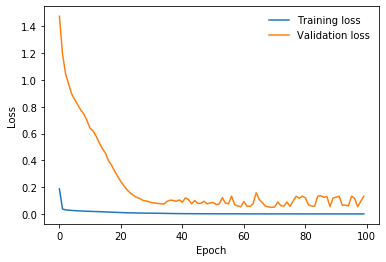

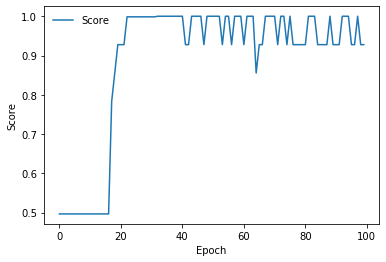

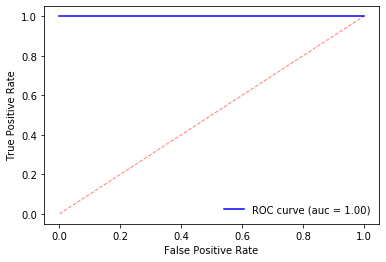

In [25]:
resultado.plot_graphics()

Adam, con diferencia

In [26]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_diferencia"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [27]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 1.0219195532784122 Validation loss 0.9440346360206604
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 0.5174698800214679 Validation loss 1.3126647472381592
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 0.04195747556667134 Validation loss 0.9399794340133667
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 0.1272325706666482 Validation loss 2.5091686248779297
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.1966478839919374 Validation loss 3.6103622913360596
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 0.05180369336569925 Validation loss 3.416088342666626
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 0.008940323096235495 Validation loss 5.044382572174072
M

Score 0.8461228609085083 at epoch 59
Epoch: 59 Train loss 0.004859359243870953 Validation loss 15.311429023742676
Score 0.8461228609085083 at epoch 60
Epoch: 60 Train loss 0.00485824170803848 Validation loss 15.34339427947998
Score 0.8461228609085083 at epoch 61
Epoch: 61 Train loss 0.004862077201027835 Validation loss 15.370433807373047
Score 0.8461228609085083 at epoch 62
Epoch: 62 Train loss 0.004846160827749192 Validation loss 15.394753456115723
Score 0.8461228609085083 at epoch 63
Epoch: 63 Train loss 0.004858426995007939 Validation loss 15.426156044006348
Score 0.8461228609085083 at epoch 64
Epoch: 64 Train loss 0.004845265103206588 Validation loss 15.448272705078125
Score 0.8461228609085083 at epoch 65
Epoch: 65 Train loss 0.004852796508873417 Validation loss 15.470094680786133
Score 0.8461228609085083 at epoch 66
Epoch: 66 Train loss 0.004864766468872895 Validation loss 15.489715576171875
Score 0.8461228609085083 at epoch 67
Epoch: 67 Train loss 0.004868643113963434 Validation 

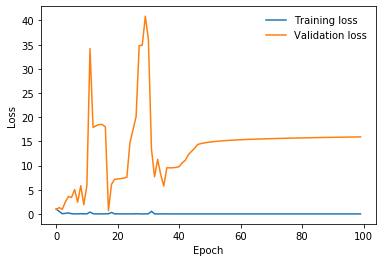

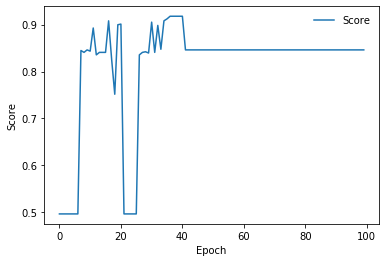

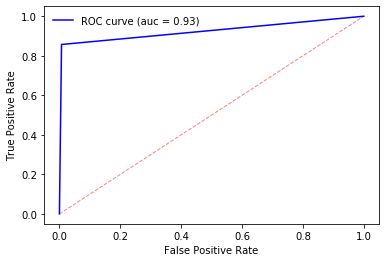

In [28]:
resultado.plot_graphics()

ADAM, solo filtro

In [31]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron().to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_cross_solo_filtro"
weights = df_train['LABEL'].value_counts()
weights  = torch.tensor([max(weights)/weights[0], max(weights)/weights[1]])
criterion = torch.nn.CrossEntropyLoss(weights).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [32]:
resultado = train_cross(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 0.06401536564459379 Validation loss 1.436142921447754
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1009		1
Positivos	4		3

Acierto: 0.9950836300849915 Sensibilidad: 0.4285714328289032 Especificidad: 0.999009907245636 Score: 0.7102813720703125
New model saved
Score 0.7102813720703125 at epoch 1
Epoch: 1 Train loss 0.02355518575382467 Validation loss 0.7948094010353088
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1007		3
Positivos	3		4

Acierto: 0.9941003322601318 Sensibilidad: 0.5714285969734192 Especificidad: 0.997029721736908 Score: 0.7796024680137634
New model saved
Score 0.7796024680137634 at epoch 2
Epoch: 2 Train loss 0.028735026914891798

Score 0.9970453381538391 at epoch 53
Epoch: 53 Train loss 6.418790484044051e-06 Validation loss 0.007761253975331783
Score 0.9970453381538391 at epoch 54
Epoch: 54 Train loss 4.102732684161212e-06 Validation loss 0.00819383468478918
Score 0.9970453381538391 at epoch 55
Epoch: 55 Train loss 2.3208027718421666e-06 Validation loss 0.008659564889967442
Score 0.9970453381538391 at epoch 56
Epoch: 56 Train loss 1.3142897433107055e-06 Validation loss 0.009234831668436527
Score 0.9970453381538391 at epoch 57
Epoch: 57 Train loss 7.301349276093268e-07 Validation loss 0.009794364683330059
Score 0.9970453381538391 at epoch 58
Epoch: 58 Train loss 4.0806481934779525e-07 Validation loss 0.010384950786828995
Score 0.9970453381538391 at epoch 59
Epoch: 59 Train loss 2.2916301800105698e-07 Validation loss 0.010941908694803715
Score 0.9970453381538391 at epoch 60
Epoch: 60 Train loss 1.2946070310403992e-07 Validation loss 0.011539462953805923
Score 0.9970453381538391 at epoch 61
Epoch: 61 Train loss 7.

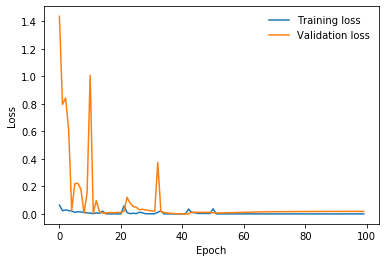

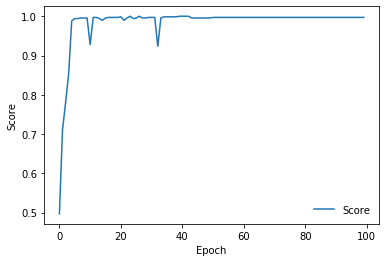

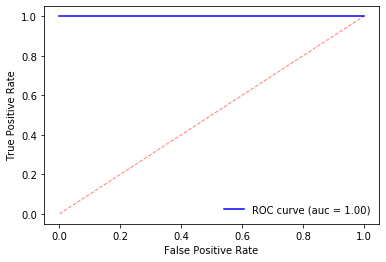

In [33]:
resultado.plot_graphics()

Cross, bce, con diferencia

In [34]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], True)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron(output = 1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_diferencia"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [35]:
resultado = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 168.39451329014634 Validation loss 11.450750350952148
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 47.82571766468312 Validation loss 5.463469505310059
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 19.130011573712128 Validation loss 1.077894687652588
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.300404215893312 Validation loss 0.17605824768543243
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 0.8553756118595924 Validation loss 1.034091830253601
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 11.896917432539286 Validation loss 0.5595511794090271
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 2.737817726938887 Validation loss 1.0450267791748047
Score 0.

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3792142308607733 Validation loss 1.3347434997558594
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3797696624692593 Validation loss 1.334861397743225
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.379128293367217 Validation loss 1.334925889968872
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.380405343399001 Validation loss 1.3348007202148438
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3798707870798557 Validation loss 1.334848165512085
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.3787725350780629 Validation loss 1.3347761631011963
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3802973287697213 Validation loss 1.3347978591918945
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3796593216186073 Validation loss 1.3348147869110107
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.3793978545531007 Validation loss 1.33480751514434

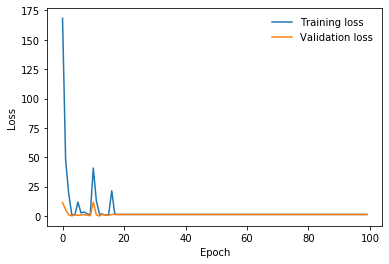

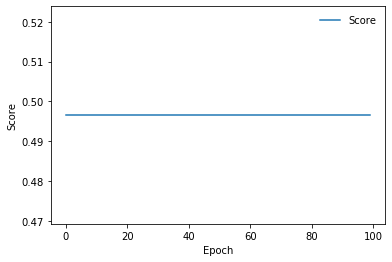

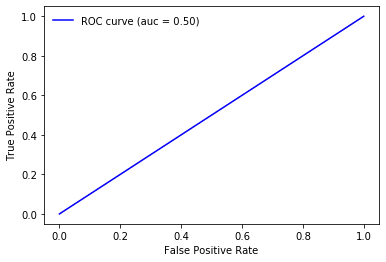

In [36]:
resultado.plot_graphics()

Cross, bce, solo filtro

In [37]:
df_train = pd.read_csv(f'{PATH}{TRAIN_FILE}', low_memory=False)
df_train['LABEL'] = df_train['LABEL'].add(-1)
df_train.iloc[:, 1:] = reduce_upper_outliers(df_train.iloc[:, 1:], 0.01)
df_train.iloc[:, 1:] = gaussian_filter(df_train.iloc[:, 1:], False)
df_train.iloc[:, 1:] = z_score_normalizing(df_train.iloc[:, 1:])
validation_proportion = 0.2
df_train, df_validation = split_train_df(df_train, validation_proportion)
modelo = Perceptron(output = 1).to(device)
model_name = os.getcwd() + "\\saved_models\\perceptron_adam_bce_solo_filtro"
weights = df_train['LABEL'].value_counts()
criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.tensor(max(weights)/weights[1])).to(device)
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate)

In [39]:
resultado = train_bce(modelo, model_name, criterion, optimizer, epochs, alpha, beta, df_train, df_validation, device)

using device cuda
Matriz de confusión:
			Predicciones
Valor real	Negativos	Positivos
Negativos	1010		0
Positivos	7		0

Acierto: 0.9931170344352722 Sensibilidad: 0.0 Especificidad: 1.0 Score: 0.4965585172176361
New model saved
Score 0.4965585172176361 at epoch 0
Epoch: 0 Train loss 9.83084838635652 Validation loss 1.3493708372116089
Score 0.4965585172176361 at epoch 1
Epoch: 1 Train loss 1.7104549737981263 Validation loss 1.2793487310409546
Score 0.4965585172176361 at epoch 2
Epoch: 2 Train loss 1.697431427862779 Validation loss 1.2712687253952026
Score 0.4965585172176361 at epoch 3
Epoch: 3 Train loss 1.642941725341928 Validation loss 1.2690026760101318
Score 0.4965585172176361 at epoch 4
Epoch: 4 Train loss 7.260899524511518 Validation loss 1.3532202243804932
Score 0.4965585172176361 at epoch 5
Epoch: 5 Train loss 1.561995652120295 Validation loss 1.2369110584259033
Score 0.4965585172176361 at epoch 6
Epoch: 6 Train loss 5.98596904952198 Validation loss 1.2816698551177979
Score 0.496

Score 0.4965585172176361 at epoch 72
Epoch: 72 Train loss 1.3805503521563087 Validation loss 1.3297289609909058
Score 0.4965585172176361 at epoch 73
Epoch: 73 Train loss 1.3799451986899833 Validation loss 1.3297697305679321
Score 0.4965585172176361 at epoch 74
Epoch: 74 Train loss 1.3796571445992303 Validation loss 1.3298465013504028
Score 0.4965585172176361 at epoch 75
Epoch: 75 Train loss 1.3794546356218746 Validation loss 1.3298649787902832
Score 0.4965585172176361 at epoch 76
Epoch: 76 Train loss 1.3800389261737795 Validation loss 1.3297580480575562
Score 0.4965585172176361 at epoch 77
Epoch: 77 Train loss 1.378309901062335 Validation loss 1.3297404050827026
Score 0.4965585172176361 at epoch 78
Epoch: 78 Train loss 1.3787720950434776 Validation loss 1.3297197818756104
Score 0.4965585172176361 at epoch 79
Epoch: 79 Train loss 1.3803240724804946 Validation loss 1.3297560214996338
Score 0.4965585172176361 at epoch 80
Epoch: 80 Train loss 1.3792207071617135 Validation loss 1.3297735452

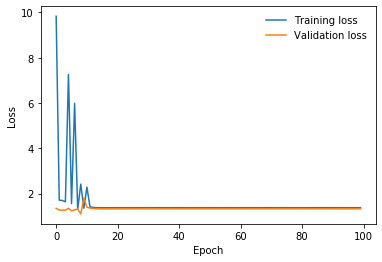

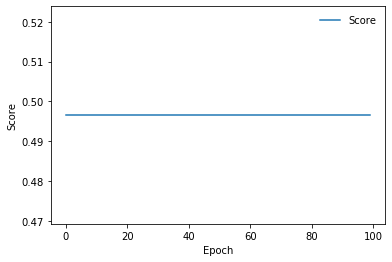

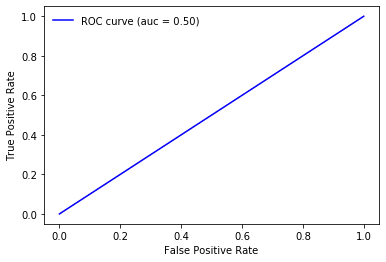

In [40]:
resultado.plot_graphics()